In [1]:
import matplotlib.pyplot as plt
import numpy as np
import helper
import time
import datetime
import torch.nn as nn
import torchvision.models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch
import pandas as pd
from torchinfo import summary
from PIL import Image
from torchvision.transforms import ToTensor
from glob import glob
from torch.utils.data import Dataset, DataLoader, random_split
from copy import copy
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.metrics import classification_report
from tqdm import tqdm
import math
from torcheval.metrics import BinaryAccuracy
import os
import timm
import segmentation_models_pytorch as smp
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from timm import create_model
import cv2
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
batch_size=2
img_size=1024
class_list=['NT_epithelial',
 'NT_immune',
 'NT_stroma',
 'Tumor',
 'NT_Muscle']
tf = ToTensor()
topilimage = torchvision.transforms.ToPILImage()
def expand2square(pil_img, background_color):
    width, height = pil_img.size
    if width == height:
        return pil_img
    elif width > height:
        result = Image.new(pil_img.mode, (width, width), background_color)
        result.paste(pil_img, (0, (width - height) // 2))
        return result
    else:
        result = Image.new(pil_img.mode, (height, height), background_color)
        result.paste(pil_img, ((height - width) // 2, 0))
        return result

/home/gil/anaconda3/envs/LeeYS/lib/python3.9/site-packages/torch/onnx/_internal/_beartype.py:36: UserWarning: unhashable type: 'list'
  warnings.warn(f"{e}")


In [2]:
img_path='../../data/area_segmentation/STMX/image/'
img_list=glob(img_path+'*.jpeg')
mask_list=[i.replace('/image/','/mask/npy/') for i in img_list]
mask_list=[i.replace('.jpeg','.npy') for i in mask_list]
train_img_list,test_img_list,train_mask_list,test_mask_list=train_test_split(img_list,mask_list,test_size=0.2,random_state=42)

test_image=torch.zeros((len(test_img_list),3,img_size,img_size))
test_mask=torch.zeros((len(test_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)    
train_image=torch.zeros((len(train_img_list),3,img_size,img_size))
train_mask=torch.zeros((len(train_img_list),len(class_list)+1,img_size,img_size),dtype=torch.float32)
np_mask=np.zeros((img_size,img_size,len(class_list)))
for i in tqdm(range(len(train_img_list))):
    train_image[i] = tf(Image.open(train_img_list[i]))
    np_mask=np.load(train_mask_list[i]).astype(np.uint8)
    one_hot_mask = np.zeros((1024, 1024, len(class_list)+1), dtype=np.int32)

        # 각 위치에 대해 mask 값에 해당하는 채널에 1을 설정
    np.put_along_axis(one_hot_mask, np_mask[..., np.newaxis], 1, axis=2)
    np_mask=one_hot_mask
    train_mask[i]=tf(np_mask)
for i in tqdm(range(len(test_img_list))):
    test_image[i] = tf(Image.open(test_img_list[i]))
    np_mask=np.load(test_mask_list[i]).astype(np.uint8)
    one_hot_mask = np.zeros((1024, 1024, len(class_list)+1), dtype=np.int32)

        # 각 위치에 대해 mask 값에 해당하는 채널에 1을 설정
    np.put_along_axis(one_hot_mask, np_mask[..., np.newaxis], 1, axis=2)
    np_mask=one_hot_mask
    test_mask[i]=tf(np_mask)


100%|██████████| 249/249 [00:55<00:00,  4.45it/s]


In [3]:
class CustomDataset(Dataset):
    def __init__(self, image_list, label_list):
        self.img_path = image_list
        self.label = label_list
        
    def trans(self,image,label):
        if random.random() > 0.5:
            transform = transforms.RandomHorizontalFlip(1)
            label = transform(label)
            image = transform(image)
            
        if random.random() > 0.5:
            transform = transforms.RandomVerticalFlip(1)
            label = transform(label)
            image = transform(image)
            
        return image,label
    
    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image_path,label_path = self.img_path[idx],self.label[idx]

        return image_path, label_path
    
train_dataset = CustomDataset(train_image, train_mask)

test_dataset = CustomDataset(test_image, test_mask)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [4]:
model = smp.DeepLabV3Plus(
        encoder_name="efficientnet-b7",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=len(class_list)+1,                      # model output channels (number of classes in your dataset) 
    ).to(device)
def dice_loss(pred, target):
    smooth = 1e-6
    dice_per_class = torch.zeros((len(pred))).to(pred.device)
    pred=F.softmax(pred,dim=1)
    for i in range(len(pred)):
        pred_class = pred[i,...]
        target_class = target[i, ...]
        
        intersection = torch.sum(pred_class * target_class)
        A_sum = torch.sum(pred_class * pred_class)
        B_sum = torch.sum(target_class * target_class)
        dice_per_class[i] =(2. * intersection + smooth) / (A_sum + B_sum + smooth)

    return 1-dice_per_class.mean()
model.load_state_dict(torch.load('../../model/areaSeg/ST_callback.pt'))
# summary(model,(batch_size,3,img_size,img_size))

/tmp/ipykernel_3072210/1366423530.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../../model/areaSeg/ST_callback.pt'))


<All keys matched successfully>

epoch: 1/1000 Step: 497 dice_loss : 0.1902 dice_score: 0.8098: 100%|██████████| 496/496 [04:45<00:00,  1.74it/s]
test epoch: 1/1000 Step: 125 dice_loss : 0.3767  dice_score: 0.6233: 100%|██████████| 124/124 [00:22<00:00,  5.63it/s]
epoch: 2/1000 Step: 497 dice_loss : 0.1919 dice_score: 0.8081: 100%|██████████| 496/496 [04:41<00:00,  1.76it/s]
test epoch: 2/1000 Step: 125 dice_loss : 0.4279  dice_score: 0.5721: 100%|██████████| 124/124 [00:21<00:00,  5.85it/s]
epoch: 3/1000 Step: 497 dice_loss : 0.2180 dice_score: 0.7820: 100%|██████████| 496/496 [04:38<00:00,  1.78it/s]
test epoch: 3/1000 Step: 125 dice_loss : 0.3978  dice_score: 0.6022: 100%|██████████| 124/124 [00:23<00:00,  5.21it/s]
epoch: 4/1000 Step: 497 dice_loss : 0.2193 dice_score: 0.7807: 100%|██████████| 496/496 [04:40<00:00,  1.77it/s]
test epoch: 4/1000 Step: 125 dice_loss : 0.3837  dice_score: 0.6163: 100%|██████████| 124/124 [00:22<00:00,  5.62it/s]
epoch: 5/1000 Step: 497 dice_loss : 0.2326 dice_score: 0.7674: 100%|████

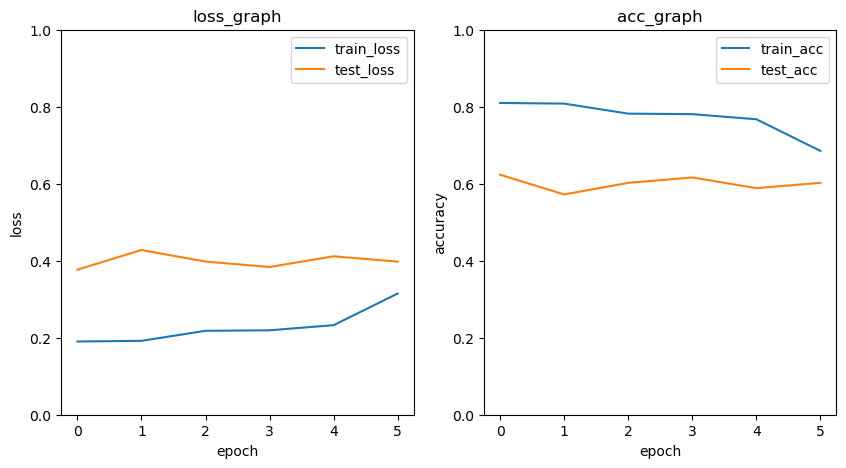

epoch: 7/1000 Step: 497 dice_loss : 0.2504 dice_score: 0.7496: 100%|██████████| 496/496 [04:35<00:00,  1.80it/s]
test epoch: 7/1000 Step: 125 dice_loss : 0.3937  dice_score: 0.6063: 100%|██████████| 124/124 [00:20<00:00,  5.94it/s]
epoch: 8/1000 Step: 497 dice_loss : 0.2210 dice_score: 0.7790: 100%|██████████| 496/496 [04:36<00:00,  1.79it/s]
test epoch: 8/1000 Step: 125 dice_loss : 0.3853  dice_score: 0.6147: 100%|██████████| 124/124 [00:21<00:00,  5.84it/s]
epoch: 9/1000 Step: 497 dice_loss : 0.2185 dice_score: 0.7815: 100%|██████████| 496/496 [04:39<00:00,  1.77it/s]
test epoch: 9/1000 Step: 125 dice_loss : 0.3880  dice_score: 0.6120: 100%|██████████| 124/124 [00:21<00:00,  5.88it/s]
epoch: 10/1000 Step: 497 dice_loss : 0.2055 dice_score: 0.7945: 100%|██████████| 496/496 [04:35<00:00,  1.80it/s]
test epoch: 10/1000 Step: 125 dice_loss : 0.3802  dice_score: 0.6198: 100%|██████████| 124/124 [00:21<00:00,  5.83it/s]
epoch: 11/1000 Step: 497 dice_loss : 0.1971 dice_score: 0.8029: 100%|█

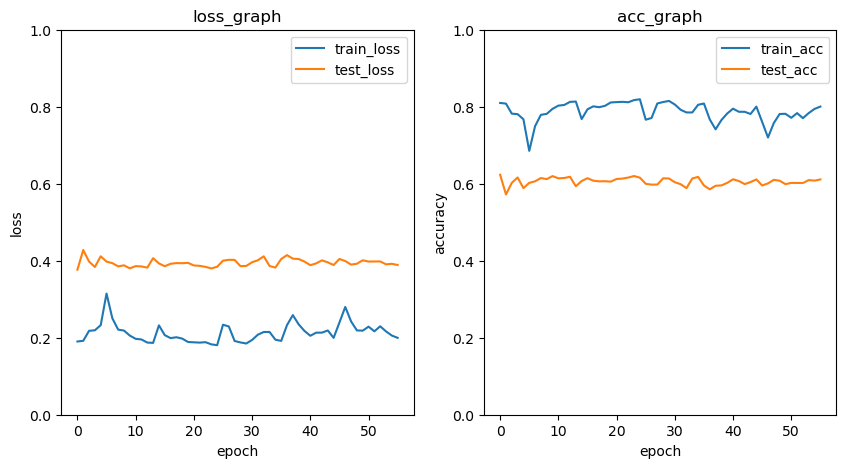

epoch: 57/1000 Step: 497 dice_loss : 0.2157 dice_score: 0.7843: 100%|██████████| 496/496 [04:17<00:00,  1.93it/s]
test epoch: 57/1000 Step: 125 dice_loss : 0.3898  dice_score: 0.6102: 100%|██████████| 124/124 [00:19<00:00,  6.24it/s]
epoch: 58/1000 Step: 497 dice_loss : 0.2428 dice_score: 0.7572: 100%|██████████| 496/496 [04:17<00:00,  1.93it/s]
test epoch: 58/1000 Step: 125 dice_loss : 0.3851  dice_score: 0.6149: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]
epoch: 59/1000 Step: 497 dice_loss : 0.2178 dice_score: 0.7822: 100%|██████████| 496/496 [04:18<00:00,  1.92it/s]
test epoch: 59/1000 Step: 125 dice_loss : 0.3953  dice_score: 0.6047: 100%|██████████| 124/124 [00:19<00:00,  6.28it/s]
epoch: 60/1000 Step: 497 dice_loss : 0.2063 dice_score: 0.7937: 100%|██████████| 496/496 [04:17<00:00,  1.93it/s]
test epoch: 60/1000 Step: 125 dice_loss : 0.4096  dice_score: 0.5904: 100%|██████████| 124/124 [00:18<00:00,  6.58it/s]
epoch: 61/1000 Step: 497 dice_loss : 0.2008 dice_score: 0.7992: 

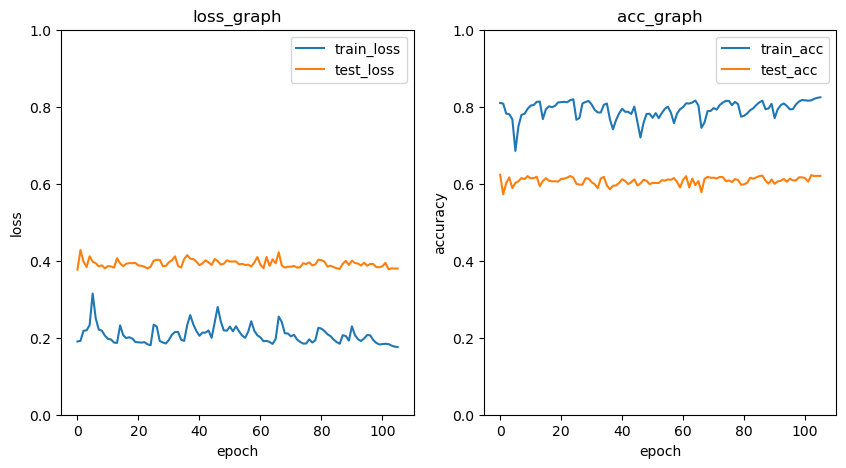

epoch: 107/1000 Step: 497 dice_loss : 0.1734 dice_score: 0.8266: 100%|██████████| 496/496 [04:16<00:00,  1.93it/s]
test epoch: 107/1000 Step: 125 dice_loss : 0.3862  dice_score: 0.6138: 100%|██████████| 124/124 [00:19<00:00,  6.21it/s]
epoch: 108/1000 Step: 497 dice_loss : 0.1726 dice_score: 0.8274: 100%|██████████| 496/496 [04:15<00:00,  1.94it/s]
test epoch: 108/1000 Step: 125 dice_loss : 0.3835  dice_score: 0.6165: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]
epoch: 109/1000 Step: 497 dice_loss : 0.1718 dice_score: 0.8282: 100%|██████████| 496/496 [04:14<00:00,  1.95it/s]
test epoch: 109/1000 Step: 125 dice_loss : 0.3800  dice_score: 0.6200: 100%|██████████| 124/124 [00:18<00:00,  6.65it/s]
epoch: 110/1000 Step: 497 dice_loss : 0.1709 dice_score: 0.8291: 100%|██████████| 496/496 [04:14<00:00,  1.95it/s]
test epoch: 110/1000 Step: 125 dice_loss : 0.3899  dice_score: 0.6101: 100%|██████████| 124/124 [00:19<00:00,  6.43it/s]
epoch: 111/1000 Step: 497 dice_loss : 0.1733 dice_score:

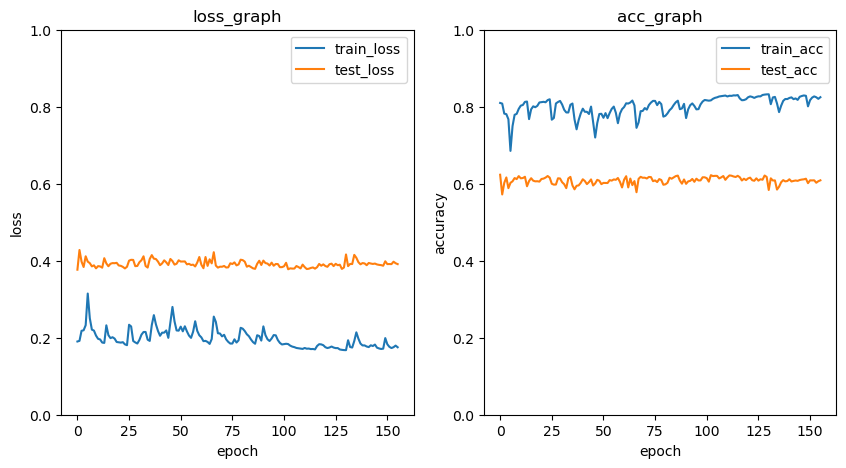

epoch: 157/1000 Step: 497 dice_loss : 0.1727 dice_score: 0.8273: 100%|██████████| 496/496 [04:18<00:00,  1.92it/s]
test epoch: 157/1000 Step: 125 dice_loss : 0.3958  dice_score: 0.6042: 100%|██████████| 124/124 [00:19<00:00,  6.26it/s]
epoch: 158/1000 Step: 497 dice_loss : 0.1720 dice_score: 0.8280: 100%|██████████| 496/496 [04:17<00:00,  1.93it/s]
test epoch: 158/1000 Step: 125 dice_loss : 0.3910  dice_score: 0.6090: 100%|██████████| 124/124 [00:19<00:00,  6.49it/s]
epoch: 159/1000 Step: 497 dice_loss : 0.1699 dice_score: 0.8301: 100%|██████████| 496/496 [04:16<00:00,  1.93it/s]
test epoch: 159/1000 Step: 125 dice_loss : 0.3955  dice_score: 0.6045: 100%|██████████| 124/124 [00:19<00:00,  6.27it/s]
epoch: 160/1000 Step: 497 dice_loss : 0.1703 dice_score: 0.8297: 100%|██████████| 496/496 [04:16<00:00,  1.94it/s]
test epoch: 160/1000 Step: 125 dice_loss : 0.3852  dice_score: 0.6148: 100%|██████████| 124/124 [00:18<00:00,  6.54it/s]
epoch: 161/1000 Step: 497 dice_loss : 0.1690 dice_score:

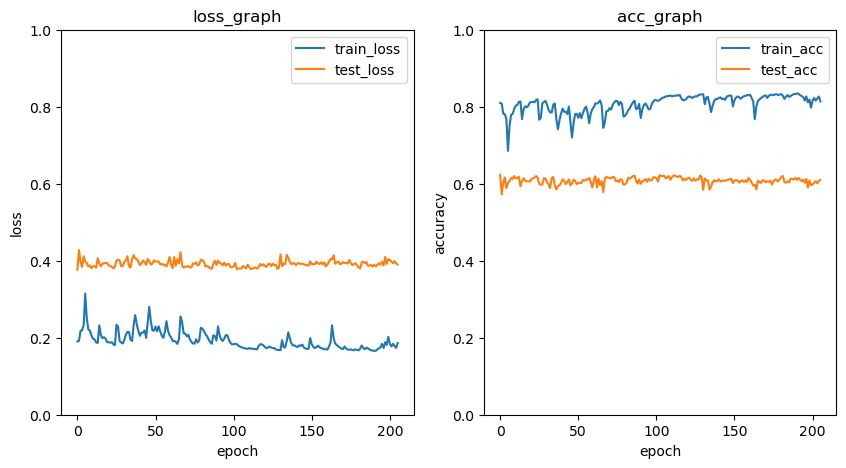

epoch: 207/1000 Step: 497 dice_loss : 0.1760 dice_score: 0.8240: 100%|██████████| 496/496 [04:11<00:00,  1.98it/s]
test epoch: 207/1000 Step: 125 dice_loss : 0.3928  dice_score: 0.6072: 100%|██████████| 124/124 [00:18<00:00,  6.87it/s]
epoch: 208/1000 Step: 497 dice_loss : 0.1719 dice_score: 0.8281: 100%|██████████| 496/496 [04:10<00:00,  1.98it/s]
test epoch: 208/1000 Step: 125 dice_loss : 0.3900  dice_score: 0.6100: 100%|██████████| 124/124 [00:18<00:00,  6.88it/s]
epoch: 209/1000 Step: 497 dice_loss : 0.1720 dice_score: 0.8280: 100%|██████████| 496/496 [04:11<00:00,  1.98it/s]
test epoch: 209/1000 Step: 125 dice_loss : 0.3971  dice_score: 0.6029: 100%|██████████| 124/124 [00:18<00:00,  6.84it/s]
epoch: 210/1000 Step: 497 dice_loss : 0.1712 dice_score: 0.8288: 100%|██████████| 496/496 [04:11<00:00,  1.97it/s]
test epoch: 210/1000 Step: 125 dice_loss : 0.3920  dice_score: 0.6080: 100%|██████████| 124/124 [00:18<00:00,  6.79it/s]
epoch: 211/1000 Step: 497 dice_loss : 0.1887 dice_score:

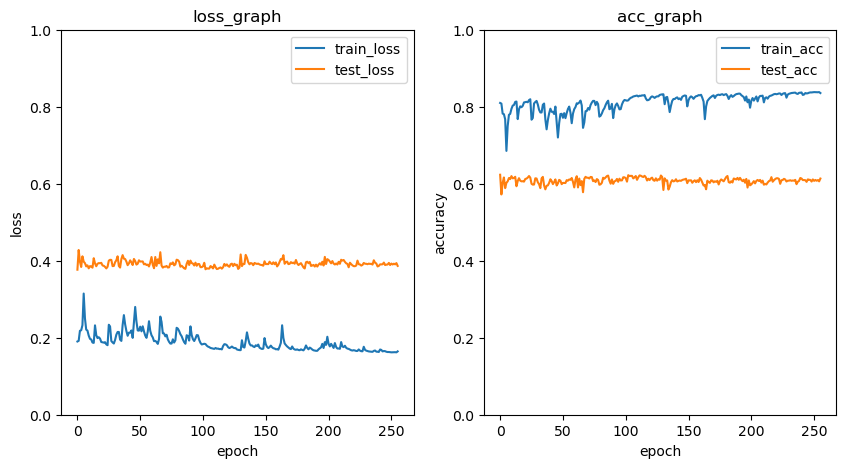

epoch: 257/1000 Step: 497 dice_loss : 0.1645 dice_score: 0.8355: 100%|██████████| 496/496 [04:10<00:00,  1.98it/s]
test epoch: 257/1000 Step: 125 dice_loss : 0.3932  dice_score: 0.6068: 100%|██████████| 124/124 [00:18<00:00,  6.78it/s]
epoch: 258/1000 Step: 497 dice_loss : 0.1638 dice_score: 0.8362: 100%|██████████| 496/496 [04:10<00:00,  1.98it/s]
test epoch: 258/1000 Step: 125 dice_loss : 0.3946  dice_score: 0.6054: 100%|██████████| 124/124 [00:18<00:00,  6.75it/s]
epoch: 259/1000 Step: 497 dice_loss : 0.1627 dice_score: 0.8373: 100%|██████████| 496/496 [04:10<00:00,  1.98it/s]
test epoch: 259/1000 Step: 125 dice_loss : 0.3974  dice_score: 0.6026: 100%|██████████| 124/124 [00:19<00:00,  6.46it/s]
epoch: 260/1000 Step: 497 dice_loss : 0.1619 dice_score: 0.8381: 100%|██████████| 496/496 [04:10<00:00,  1.98it/s]
test epoch: 260/1000 Step: 125 dice_loss : 0.3982  dice_score: 0.6018: 100%|██████████| 124/124 [00:18<00:00,  6.82it/s]
epoch: 261/1000 Step: 497 dice_loss : 0.1620 dice_score:

KeyboardInterrupt: 

In [5]:
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
MIN_loss=5000
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)
metrics = defaultdict(float)
for epoch in range(1000):
    train=tqdm(train_dataloader)
    count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train:
        model.train()
        y = y.to(device).float()
        count+=1
        x=x.to(device).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device)
        cost = dice_loss(predict, y) # cost 구함
        acc=1-cost.item()
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
        y = y.to('cpu')

        x=x.to('cpu')
        train.set_description(f"epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {running_loss/count:.4f} dice_score: {1-running_loss/count:.4f}")
    train_loss_list.append((running_loss/count))
    train_acc_list.append((acc_loss/count))
#test
    val=tqdm(test_dataloader)
    model.eval()
    count=0
    val_running_loss=0.0
    acc_loss=0
    with torch.no_grad():
        for x, y in val:
            y = y.to(device).float()
            count+=1
            x=x.to(device).float()
            
            predict = model(x).to(device)
            cost = dice_loss(predict, y) # cost 구함
            acc=1-cost.item()
            val_running_loss+=cost.item()
            acc_loss+=acc
            y = y.to('cpu')
            x=x.to('cpu')
            val.set_description(f"test epoch: {epoch+1}/{1000} Step: {count+1} dice_loss : {val_running_loss/count:.4f}  dice_score: {1-val_running_loss/count:.4f}")
        val_loss_list.append((val_running_loss/count))
        val_acc_list.append((acc_loss/count))
        
    if MIN_loss>(val_running_loss/count):
        torch.save(model.state_dict(), '../../model/areaSeg/ST_callback.pt')
        MIN_loss=(val_running_loss/count)
        
    if epoch%50==5:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='test_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()
print('batch size= 2')
print('image size= 1024,1024')
print('learning rate= 2e-4')